# Digit Classification with KNN 


Radhika Mardikar

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'1.0.2'

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X.iloc[shuffle], Y[shuffle]
print('data shape:', X.shape)
print('label shape:', Y.shape)


data shape: (70000, 784)
label shape: (70000,)


In [4]:
# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

# Visualize examples of each digit


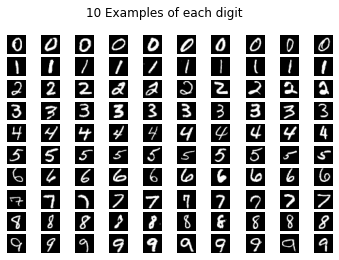

In [6]:
def digitshower(num_examples=10):
  ycopy = Y.copy()
  xcopy = X.copy()
  ycopy = ycopy.reset_index(drop = True)
  xcopy = xcopy.reset_index(drop = True)
  plt.figure()
  for i in range(10):
    ind = ycopy[ycopy == str(i)].index[0:num_examples]
    for r,j in enumerate(ind):
      count = (i*10) + (r+1)
      imgind = xcopy.iloc[j]
      imgind = np.asarray(imgind)
      im = imgind.reshape((28,28))
      plt.subplot(10, 10, count)
      plt.axis('off')
      plt.imshow(im, cmap='gray')
  plt.suptitle('10 Examples of each digit')
  
  plt.show()

digitshower(10)

# Evaluating different choices of k

In [8]:
def kselector(k_values):

    for i in k_values:
      classi = KNeighborsClassifier(n_neighbors=i)
      classi.fit(mini_train_data, mini_train_labels)
      y_pred = classi.predict(dev_data)
      if i == 1:
        print(i, ' Neighbors classification report')
        print(classification_report(dev_labels, y_pred))
      print(i, ' Neighbors')
      print('accuracy: ', classi.score(dev_data, dev_labels))
      print()

k_values = [1, 3, 5, 7, 9]
kselector(k_values)

1  Neighbors classification report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

1  Neighbors
accuracy:  0.884

3  Neighbors
accuracy:  0.876

5  Neighbors
accuracy:  0.882

7  Neighbors
accuracy:  0.877

9  Neighbors
accuracy:  0.875



The digit that is hardest to evaluate is 9. This was chosen because it has the lowest precision score and F1 score. Precision is a percentage measure of True Positive/(False Positives + True Positives) and F1 score is a balance of Precision and Recall. The low score for precision means that the model incorrectly identifies a digit  as a 9 more than it does for other digits. Since the supports are approximately the same meaning that the classes are almost evenly distributed, we can rely on the precision and not have to look more closely at the F1-score.

# Examining the importance of training size

In [32]:
def trainsize(train_sizes, accuracies, train_times, eval_times):

  for i in train_sizes:
    train_x = train_data[:i]
    train_y = train_labels[:i]
    classi = KNeighborsClassifier(n_neighbors=1)
    start = time.time()
    classi.fit(train_x, train_y)
    elapsed = time.time() - start
    y_pred = classi.predict(dev_data)
    start1 = time.time()
    accuracy = classi.score(dev_data, dev_labels)
    evaltime = time.time() - start1
    train_times.append(elapsed)
    accuracies.append(accuracy)
    eval_times.append(evaltime)

table = pd.DataFrame()
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = []
train_times = []
eval_times = []
trainsize(train_sizes, accuracies, train_times, eval_times)
table['Training sizes'] = train_sizes
table['Accuracies'] = accuracies
table['Evaluation times'] = eval_times
table.head(10)

,Training sizes,Accuracies,Evaluation times
0,100,0.702,0.071025
1,200,0.791,0.075349
2,400,0.811,0.092232
3,800,0.866,0.115639
4,1600,0.905,0.165443
5,3200,0.927,0.260394
6,6400,0.939,0.463009
7,12800,0.952,0.860430
8,25600,0.963,1.600156


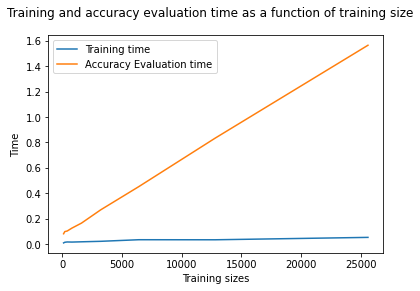

In [12]:
plt.plot(train_sizes, train_times, label = 'Training time')
plt.plot(train_sizes, eval_times, label = "Accuracy Evaluation time" )
plt.xlabel("Training sizes")
plt.ylabel("Time")
plt.suptitle('Training and accuracy evaluation time as a function of training size')
plt.legend()

As training sizes increase, the training time increases which is expected because the model has more data to process. The time to evaluate accuracy is surprising since the measurement should only take into account the predicted values and the development labels. However, this behavior is explained by how the function score works. Since the score function calls the predict method to evaluate accuracy, the time ends up being longer.

# Evaluating if we should obtain additional data



Predictions for training sizes of 60000, 120000, and 1000000 respectively:  [1.23617317 1.63742805 7.52249967]
R2 score of untransformed linear model:  0.4177006634161019


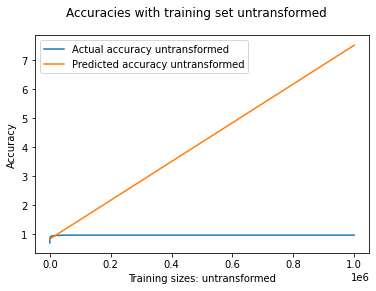



Predictions for training sizes of 60000, 120000, and 1000000 respectively:  [0.9757526385894685, 0.9818668246560979, 0.9926057178833572]
R2 score of transformed linear model:  0.9897378265316935


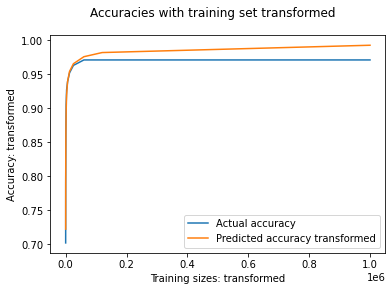

In [33]:
from sklearn.metrics import r2_score
import math
def getmoredata():


  #untransformed model
  xtrain = train_sizes.copy()
  xtrai = train_sizes.copy()
  xtrain = np.asarray(xtrain)
  xtrain = xtrain.reshape(-1,1)
  ytrain = accuracies.copy()

  ytest = [knnmodel(60000), knnmodel(120000), knnmodel(1000000)]
  testlist = [60000, 120000, 1000000]
  xtest = np.array(testlist)
  xtest = xtest.reshape(-1,1)
  combined = np.append(xtrain, xtest) 
  combined = combined.reshape(-1, 1)
  combine = xtrai.append(testlist)
  together = np.append(ytrain, ytest)
  
  linreg = LinearRegression()
  linreg.fit(xtrain, ytrain)
  ypredi = linreg.predict(xtest)
  complete = linreg.predict(combined)


  print()
  print("Predictions for training sizes of 60000, 120000, and 1000000 respectively: ", ypredi)
  print("R2 score of untransformed linear model: ", linreg.score(xtrain, ytrain))
  
  plt1 = plt.plot(combined, together, label = 'Actual accuracy untransformed')
  plt1 = plt.plot(combined, complete, label = "Predicted accuracy untransformed" )
  plt1 = plt.xlabel("Training sizes: untransformed")
  plt1 = plt.ylabel("Accuracy")
  plt1 = plt.legend()
  plt.suptitle("Accuracies with training set untransformed")
  plt.show()

  #transformed model
  xtraintrans = [math.log(i) for i in train_sizes.copy()]
  ytraintrans = [antisigmoid(i) for i in accuracies.copy()]
  xtesttrans = [math.log(i) for i in testlist]
  xtraintrans = np.asarray(xtraintrans)
  xtraintrans = xtraintrans.reshape(-1,1)
  xtesttrans = np.asarray(xtesttrans)
  xtesttrans = xtesttrans.reshape(-1,1)
  combinedtrans = np.append(xtraintrans, xtesttrans)
  combinedtrans = combinedtrans.reshape(-1, 1)
  
  linregtrans = LinearRegression()
  linregtrans.fit(xtraintrans, ytraintrans) 
  ypreditrans = linregtrans.predict(xtesttrans)
  completetrans = linregtrans.predict(combinedtrans)
  ypreditranslog = [sigmoid(i) for i in ypreditrans.copy()]
  completetranslog = [sigmoid(i) for i in completetrans.copy()]
  
  
  print()
  print()
  print("Predictions for training sizes of 60000, 120000, and 1000000 respectively: ", ypreditranslog)
  print("R2 score of transformed linear model: ", linregtrans.score(xtraintrans, ytraintrans))

  plt2 = plt.plot(combined, together, label = 'Actual accuracy')
  plt2 = plt.plot(combined, completetranslog, label = "Predicted accuracy transformed" )
  plt2 = plt.xlabel("Training sizes: transformed")
  plt2 = plt.ylabel("Accuracy: transformed")
  plt2 = plt.legend()
  plt.suptitle("Accuracies with training set transformed")

  plt.show()

def knnmodel(trainingsize):
  train_x = train_data[:trainingsize]
  train_y = train_labels[:trainingsize]
  classi = KNeighborsClassifier(n_neighbors=1)
  classi.fit(train_x, train_y)
  y_pred = classi.predict(dev_data)
  start1 = time.time()
  accuracy = classi.score(dev_data, dev_labels)
  return accuracy

def sigmoid(x):
  return (math.exp(x))/(1 + math.exp(x))

def antisigmoid(x):
  return math.log(x/(1-x))

getmoredata()

2 things wrong with the model: 
  1. in the untransformed space, the predicted accuracy goes way above the reasonable range.
  2. The accuracy is a linear model instead of a logistic model. This way it will never plateau, rather it will continue to increase linearly.

When transforming the training sizes with a log transform and transforming the accuracy with a logit function, we train the linear model. Retransforming the predicted values and the inputs back into the original axes, we see the predicted accuracies approach the values that make sense in a range that is reasonable.

# Make a confusion matrix.


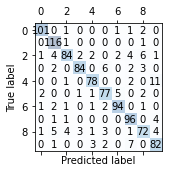

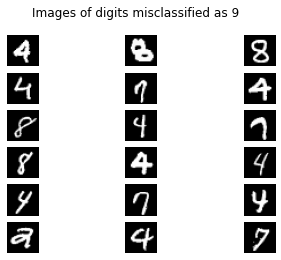

In [31]:
def matrixmaker():

  devdatacopy = dev_data.copy()
  devlabelcopy = dev_labels.copy()
  devdatacopy = devdatacopy.reset_index(drop = True)
  devlabelcopy = devlabelcopy.reset_index(drop = True)
  classifier = KNeighborsClassifier(n_neighbors=1)
  classifier.fit(mini_train_data, mini_train_labels)
  pred = classifier.predict(devdatacopy)
  confusion_matrix_plot(confusion_matrix(devlabelcopy, pred))
  print()
  listofnine = devlabelcopy[devlabelcopy=='9'].index
  ninesinpred = matcher(pred)
  difference = [i for i in ninesinpred if i not in listofnine]
  imageshower(difference, devdatacopy)

def matcher(passlist):
  result = []
  for r, i in enumerate(passlist):
    if i == '9':
      result.append(r)
  return result

def imageshower(indices, x):
  count = 1
  for i in indices:
    imgind = x.iloc[i]
    imgind = np.asarray(imgind)
    im = imgind.reshape((28,28))
    plt.imshow(im, cmap='gray')
    if count == 19:
      break
    plt.subplot(6, 3, count)
    plt.axis('off')
    count += 1
  plt.suptitle("Images of digits misclassified as 9")
  plt.show()

# From Cornelia Ilin's notebook
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()


matrixmaker()

4 is most often mistaken as a 9 but the same is not true the other way around. This was determined by looking at the confusion matrix which indicates the amount of images classified into a certain label. Number 4 had the highest number of misclassifications overall in the 9th label which means that many 4s were mislabeled as 9s. The subplot below the confusion matrix shows all the digits that were misclassified as 9 and it is apparent that 4 is the most common.


As a note: the code for the confusion matrix plot comes from Cornelia Ilin's notebook which can be found at https://github.com/MIDS-W207/cilin-coursework/blob/master/live_sessions/week02/knn_classifier%20(scikit_class).ipynb